### Setup the Spark VM and complete the below assignment

Objective:- Build a ML model to predict the employee compensation.
The application should be modelled using Spark.

You can refer to the below links for spark commands:- 
- https://spark.apache.org/docs/latest/ml-pipeline.html

- https://github.com/spark-in-action/first-edition

- https://github.com/FavioVazquez/first_spark_model

# Predicting Employee Compensation

## Data Dictionary
<br>**Year Type** - Fiscal (July through June) or Calendar (January through December)
<br>**Year** - An accounting period of 12 months. The City and County of San Francisco operates on a fiscal year that begins on July 1 and ends on June 30 the following year. The Fiscal Year ending June 30, 2012 is represented as FY2011-2012.
<br>**Organization Group Code** - Org Group is a group of Departments. For example, the Public Protection Org Group includes departments such as the Police,Fire, Adult Probation, District Attorney, and Sheriff.
<br> **Organization Group** - Org Group is a group of Departments. For example, the Public Protection Org Group includes departments such as the Police,
Fire, Adult Probation, District Attorney, and Sheriff.
<br>**Department Code** - Departments are the primary organizational unit used by the Cityand County of San Francisco. Examples include Recreation and
Parks, Public Works, and the Police Department.
<br>**Department Code** - Departments are the primary organizational unit used by the City and County of San Francisco. Examples include Recreation and Parks, Public Works, and the Police Department.
<br>**Union Code** - Unions represent employees in collective bargaining agreements. A job belongs to one union, although some jobs are unrepresented (usually temporarily).
<br>**Union** - Unions represent employees in collective bargaining agreements. A job belongs to one union, although some jobs are unrepresented (usually temporarily).
<br>**Job Family Code** Job Family combines similar Jobs into meaningful groups.
<br>**Job Family** Job Family combines similar Jobs into meaningful groups.
<br>**Employee Identifier** Each distinct number in the “Employee Identifier” column represents one employee. These identifying numbers are not meaningful but rather are randomly assigned for the purpose of building this dataset. The column does not appear on the
Employee Compensation report hosted on openbook.sfgov.org,
but that report does show one row for each employee. Employee
ID has been included here to allow users to reconstruct the
original report. Note that each employee’s identifier will change
each time this dataset is updated, so comparisons by employee
across multiple versions of the dataset are not possible.
<br>**Salaries** - Normal salaries paid to permanent or temporary City employees.
<br>**Overtime** - Amounts paid to City employees working in excess of 40 hours
per week.
<br>**Other Salaries** - Various irregular payments made to City employees including premium pay, incentive pay, or other one-time payments. Total Salary Number The sum of all salaries paid to City employees.
<br>**Retirement** City contributions to employee retirement plans.
<br>**Health/Dental** City-paid premiums to health and dental insurance plans covering City employees. To protect confidentiality as legally required, pro-rated citywide averages are presented in lieu of employee-specific health and dental benefits.
<br>**Other Benefits** Mandatory benefits paid on behalf of employees, such as Social Security (FICA and Medicare) contributions, unemployment
insurance premiums, and minor discretionary benefits not included in the above categories.
<br>**Total Benefits** The sum of all benefits paid to City employees.
<br>**Total Compensation** The sum of all salaries and benefits paid to City employees.

Read the data and answer the following questions to predict employee compensation

In [53]:
# Imports
import os
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col, expr, when, isnull, isnan, count, sum, countDistinct, corr, round
from pyspark.sql.types import IntegerType, FloatType, DecimalType, DoubleType
from pyspark.ml.feature import Imputer, StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml.stat import Correlation
from pyspark.ml.linalg import Vectors
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, LinearRegressionModel
from pyspark.ml.evaluation import RegressionEvaluator

In [5]:
#Create SparkSession,
if 'spark' not in globals():
    spark = SparkSession.builder.appName('nycparking').getOrCreate()
else:
    print(f'Spark {spark.version} is already initalized.')

Spark 3.3.1 is already initalized.


## 1. Read the Data

In [6]:
# Define dataset path and Read data
DATA_DIR = "/mnt/c/Users/raveendra sawkar/Documents/IITH Docs/IIITH Assgn/Spark/"
original_df = spark.read.option("header", True).csv(os.path.join(DATA_DIR, 'Employee_Compensation.csv'))

In [7]:
# Copy and check dataset
df = original_df
df.limit(5).toPandas().head()

,Year Type,Year,Organization Group Code,Organization Group,Department Code,Department,Union Code,Union,Job Family Code,Job Family,...,Employee Identifier,Salaries,Overtime,Other Salaries,Total Salary,Retirement,Health/Dental,Other Benefits,Total Benefits,Total Compensation
0,Fiscal,2016,01,Public Protection,DAT,District Attorney,311,Municipal Attorneys' Association,8100,Legal & Court,...,49919,114473.16,0,1500,115973.16,21025.98,13068.8,9368.71,43463.49,159436.65
1,Calendar,2013,05,Culture & Recreation,ART,Arts Commission,790,"SEIU - Miscellaneous, Local 1021",1800,"Budget, Admn & Stats Analysis",...,1225,84077.11,0,0,84077.11,16587.3,12457.73,6931.91,35976.94,120054.05
2,Calendar,2015,04,Community Health,DPH,Public Health,535,"SEIU - Human Services, Local 1021",2900,Human Services,...,34873,9980.17,0,798.43,10778.6,0,2254.93,835.11,3090.04,13868.64
3,Fiscal,2015,04,Community Health,DPH,Public Health,250,"SEIU - Health Workers, Local 1021",2200,Medical & Dental,...,51145,2873.41,0,0,2873.41,0,622.63,222.46,845.09,3718.5
4,Fiscal,2014,05,Culture & Recreation,REC,Recreation and Park Commission,790,"SEIU - Miscellaneous, Local 1021",3200,Recreation,...,48705,6701.85,0,176.7,6878.55,0,2711.66,538.43,3250.09,10128.64


In [8]:
# Rename columns to remove spaces
columns = df.columns
new_columns = [col_name.replace(" ", "_") for col_name in columns]
df = df.select(*columns).toDF(*new_columns)
df = df.withColumnRenamed("Health/Dental","Health_Dental")

### 1.1 Display the number of rows and columns in the dataset

In [11]:
# Check shape of dataframe
print(f'Rows: {df.count()}, Columns: {len(df.columns)}')

Rows: 291825, Columns: 22


### 1.2 Check the datatype of the variables

In [12]:
# Check schema with datatypes
df.printSchema()

root
 |-- Year_Type: string (nullable = true)
 |-- Year: string (nullable = true)
 |-- Organization_Group_Code: string (nullable = true)
 |-- Organization_Group: string (nullable = true)
 |-- Department_Code: string (nullable = true)
 |-- Department: string (nullable = true)
 |-- Union_Code: string (nullable = true)
 |-- Union: string (nullable = true)
 |-- Job_Family_Code: string (nullable = true)
 |-- Job_Family: string (nullable = true)
 |-- Job_Code: string (nullable = true)
 |-- Job: string (nullable = true)
 |-- Employee_Identifier: string (nullable = true)
 |-- Salaries: string (nullable = true)
 |-- Overtime: string (nullable = true)
 |-- Other_Salaries: string (nullable = true)
 |-- Total_Salary: string (nullable = true)
 |-- Retirement: string (nullable = true)
 |-- Health_Dental: string (nullable = true)
 |-- Other_Benefits: string (nullable = true)
 |-- Total_Benefits: string (nullable = true)
 |-- Total_Compensation: string (nullable = true)



### 2. Convert the incorrect column type into its suitable column type. And drop the redundant features

In [13]:
# Drop unnecessary or duplicate columns
cols = ("Organization_Group", "Department", "Union", "Job_Family", "Job", "Job_Code", "Employee_Identifier")
df = df.drop(*cols)

In [14]:
# Type cast column to relevant datatypes
df = df.withColumn("Salaries",df.Salaries.cast(FloatType())) \
    .withColumn("Overtime",df.Overtime.cast(FloatType())) \
    .withColumn("Other_Salaries",df.Other_Salaries.cast(FloatType())) \
    .withColumn("Total_Salary",df.Total_Salary.cast(FloatType())) \
    .withColumn("Retirement",df.Retirement.cast(FloatType())) \
    .withColumn("Health_Dental",df.Health_Dental.cast(FloatType())) \
    .withColumn("Other_Benefits",df.Other_Benefits.cast(FloatType())) \
    .withColumn("Total_Benefits",df.Total_Benefits.cast(FloatType())) \
    .withColumn("Total_Compensation",df.Total_Compensation.cast(FloatType()))
df.printSchema()

root
 |-- Year_Type: string (nullable = true)
 |-- Year: string (nullable = true)
 |-- Organization_Group_Code: string (nullable = true)
 |-- Department_Code: string (nullable = true)
 |-- Union_Code: string (nullable = true)
 |-- Job_Family_Code: string (nullable = true)
 |-- Salaries: float (nullable = true)
 |-- Overtime: float (nullable = true)
 |-- Other_Salaries: float (nullable = true)
 |-- Total_Salary: float (nullable = true)
 |-- Retirement: float (nullable = true)
 |-- Health_Dental: float (nullable = true)
 |-- Other_Benefits: float (nullable = true)
 |-- Total_Benefits: float (nullable = true)
 |-- Total_Compensation: float (nullable = true)



### 3. Check basic statistics and perform necessary data preprocessing (Like removing negative amount)

In [15]:
# Check basic stats of dataset
df.summary().toPandas()

,summary,Year_Type,Year,Organization_Group_Code,Department_Code,Union_Code,Job_Family_Code,Salaries,Overtime,Other_Salaries,Total_Salary,Retirement,Health_Dental,Other_Benefits,Total_Benefits,Total_Compensation
0,count,291825,291825,291825,291825,291782,291780,291825,291825,291825,291825,291825,291825,291825,291825,291825
1,mean,None,2014.325061252463,2.9770513150004283,None,489.5060764543392,4778.5595401977025,63210.17290999104,4406.8774410083815,3781.0328697833183,71398.0832117191,12937.728952135096,8921.893733006405,4644.276406892767,26503.899093420772,97901.98229523769
2,stddev,None,1.032265272549936,1.5777709265315074,None,333.7611361507335,3090.283171744259,44660.46232900241,11079.405933260676,7697.66531390166,52224.21411840513,9785.06480160153,4900.31808488437,3787.907010265397,16800.143144914553,67777.549157382
3,min,Calendar,2013,01,AAM,001,0900,-68771.78,-12308.66,-19131.1,-68771.78,-30621.43,-2940.47,-10636.5,-21295.15,-74082.61
4,25%,None,2013.0,2.0,None,216.0,2300.0,23275.93,0.0,0.0,25275.87,3546.49,4314.76,1586.83,9599.48,35799.22
5,50%,None,2014.0,2.0,None,535.0,3200.0,62511.27,0.0,696.4,67842.58,13167.03,11964.76,4348.75,30315.66,98004.94
6,75%,None,2015.0,4.0,None,790.0,8100.0,92886.07,2763.26,4619.26,103123.02,19568.03,12801.79,6828.24,38718.67,142040.19
7,max,Fiscal,2016,07,WTR,990,SFRA,515101.8,227313.62,342802.62,515101.8,105052.98,21872.8,35157.63,141043.64,653498.1


In [16]:
# Remove negative values in columns
for col_name in df.columns:
    df = df.withColumn(col_name, when(df[col_name] < 0, float("NaN")).otherwise(df[col_name]))

### 4. Perform Missing Value Analysis

In [17]:
# Check for NaN values
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show(vertical=True)

-RECORD 0----------------------
 Year_Type               | 0   
 Year                    | 0   
 Organization_Group_Code | 0   
 Department_Code         | 0   
 Union_Code              | 0   
 Job_Family_Code         | 0   
 Salaries                | 79  
 Overtime                | 30  
 Other_Salaries          | 62  
 Total_Salary            | 51  
 Retirement              | 422 
 Health_Dental           | 344 
 Other_Benefits          | 679 
 Total_Benefits          | 449 
 Total_Compensation      | 246 



In [18]:
# Check for Null values
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show(vertical=True)

-RECORD 0----------------------
 Year_Type               | 0   
 Year                    | 0   
 Organization_Group_Code | 0   
 Department_Code         | 0   
 Union_Code              | 43  
 Job_Family_Code         | 45  
 Salaries                | 0   
 Overtime                | 0   
 Other_Salaries          | 0   
 Total_Salary            | 0   
 Retirement              | 0   
 Health_Dental           | 0   
 Other_Benefits          | 0   
 Total_Benefits          | 0   
 Total_Compensation      | 0   



In [19]:
# Drop NaN values in Target Column
df = df.na.drop(subset=["Total_Compensation"])

# Create list of columns to impute with mean and mode
mean_imputation_cols = ['Salaries', 'Overtime', 'Other_Salaries', 'Total_Salary', 'Retirement', 'Health_Dental', 'Other_Benefits', 'Total_Benefits']
mode_imputation_cols = ['Union_Code', 'Job_Family_Code']

#Get modes of categorical columns and impute
modes = [df.groupby(c).count().orderBy("count", ascending=False).first()[0] for c in mode_imputation_cols]
df = df.na.fill({ 'Union_Code':modes[0], 'Job_Family_Code':modes[1] })

# Impute Numerical columns with mean
mean_imputer = Imputer(inputCols = mean_imputation_cols, \
                       outputCols = ["{}_Imputed".format(c) for c in mean_imputation_cols]).setStrategy("mean")
df = mean_imputer.fit(df).transform(df)

# Drop old columns and keep only imputed columns
df = df.drop(*mean_imputation_cols)

In [20]:
# Get the list of double columns in the dataframe
double_columns = [field.name for field in df.schema.fields if isinstance(field.dataType, DoubleType)]

# Round the values in double type columns to 2 decimal places
for col_name in double_columns:
    df = df.withColumn(col_name, round(df[col_name], 2))

In [21]:
# Check dataframe after above transformations
df.toPandas().head()

,Year_Type,Year,Organization_Group_Code,Department_Code,Union_Code,Job_Family_Code,Total_Compensation,Salaries_Imputed,Overtime_Imputed,Other_Salaries_Imputed,Total_Salary_Imputed,Retirement_Imputed,Health_Dental_Imputed,Other_Benefits_Imputed,Total_Benefits_Imputed
0,Fiscal,2016,01,DAT,311,8100,159436.66,114473.16,0.0,1500.00,115973.16,21025.98,13068.80,9368.71,43463.49
1,Calendar,2013,05,ART,790,1800,120054.05,84077.11,0.0,0.00,84077.11,16587.30,12457.73,6931.91,35976.94
2,Calendar,2015,04,DPH,535,2900,13868.64,9980.17,0.0,798.43,10778.60,0.00,2254.93,835.11,3090.04
3,Fiscal,2015,04,DPH,250,2200,3718.50,2873.41,0.0,0.00,2873.41,0.00,622.63,222.46,845.09
4,Fiscal,2014,05,REC,790,3200,10128.64,6701.85,0.0,176.70,6878.55,0.00,2711.66,538.43,3250.09


### 5. Exploratory Data Analysis

#### 5.1. Find top compensating organizations. Display using bar plot

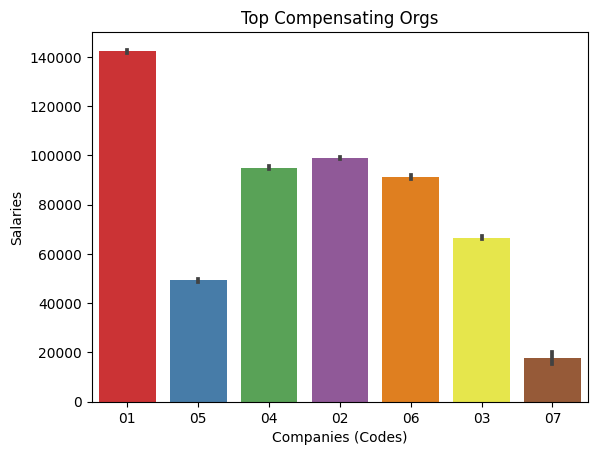

In [22]:
# Get values of columns to plot from dataframe as seaborn does not work with PySpark dataframe
x_vals = [val.Organization_Group_Code for val in df.select('Organization_Group_Code').collect()]
y_vals = [val.Total_Compensation for val in df.select('Total_Compensation').collect()]

# Plot graph
sns.barplot(x = x_vals, y = y_vals, palette='Set1')
plt.xlabel('Companies (Codes)')
plt.ylabel('Salaries')
plt.title('Top Compensating Orgs')
# plt.legend(['Organization_Group_Code', 'Total_Compensation'], loc='upper right')

plt.show()

#### 5.2. Find top Compensating Jobs. Display using bar plot

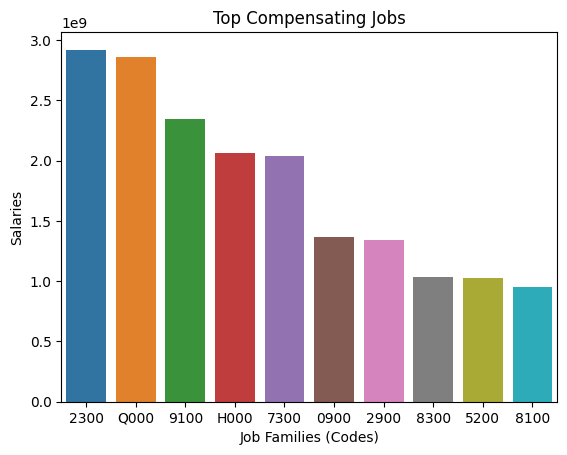

In [24]:
# Convert the 'Total_Compensation' column to DecimalType
# df = df.withColumn("Total_Compensation", df["Total_Compensation"].cast(DecimalType(38,2)))

# Gather top 10 values to plot
# Group the dataframe by 'Organization_Group_Code' and sum the values of 'Total_Compensation'
grouped_vals = df.groupBy('Job_Family_Code').agg(sum('Total_Compensation').alias('Total_Compensation'))

# Sort the resulting dataframe by 'Total_Compensation' in descending order
grouped_vals = grouped_vals.sort(col('Total_Compensation').desc())

# Get the top 10 rows of the sorted dataframe get column values to plot
grouped_vals = grouped_vals.limit(10)
x_vals = [val.Job_Family_Code for val in grouped_vals.select('Job_Family_Code').collect()]
y_vals = [val.Total_Compensation for val in grouped_vals.select('Total_Compensation').collect()]

# Plot graph
sns.barplot(x = x_vals, y = y_vals)
plt.xlabel('Job Families (Codes)')
plt.ylabel('Salaries')
plt.title('Top Compensating Jobs')
# plt.legend(['Job_Family_Code', 'Total_Compensation'], loc='upper right')

plt.show()

#### 5.3. Check Correlation of Target Variable with Other Independent Variables. Plot Heatmap

In [25]:
# Index categorical columns to create a Correlation Matrix
df = StringIndexer(inputCols=["Year_Type", "Year", "Department_Code", "Union_Code",\
                                   "Job_Family_Code", "Organization_Group_Code"], \
                  outputCols=["Year_Type_Index", "Year_Index", "Department_Code_Index", "Union_Code_Index",\
                                   "Job_Family_Code_Index", "Organization_Group_Code_Index"]).fit(df).transform(df)
df = df.drop(*["Year_Type","Year","Department_Code","Union_Code","Job_Family_Code","Organization_Group_Code"])

23/02/12 23:19:08 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/02/12 23:19:08 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


<AxesSubplot: >

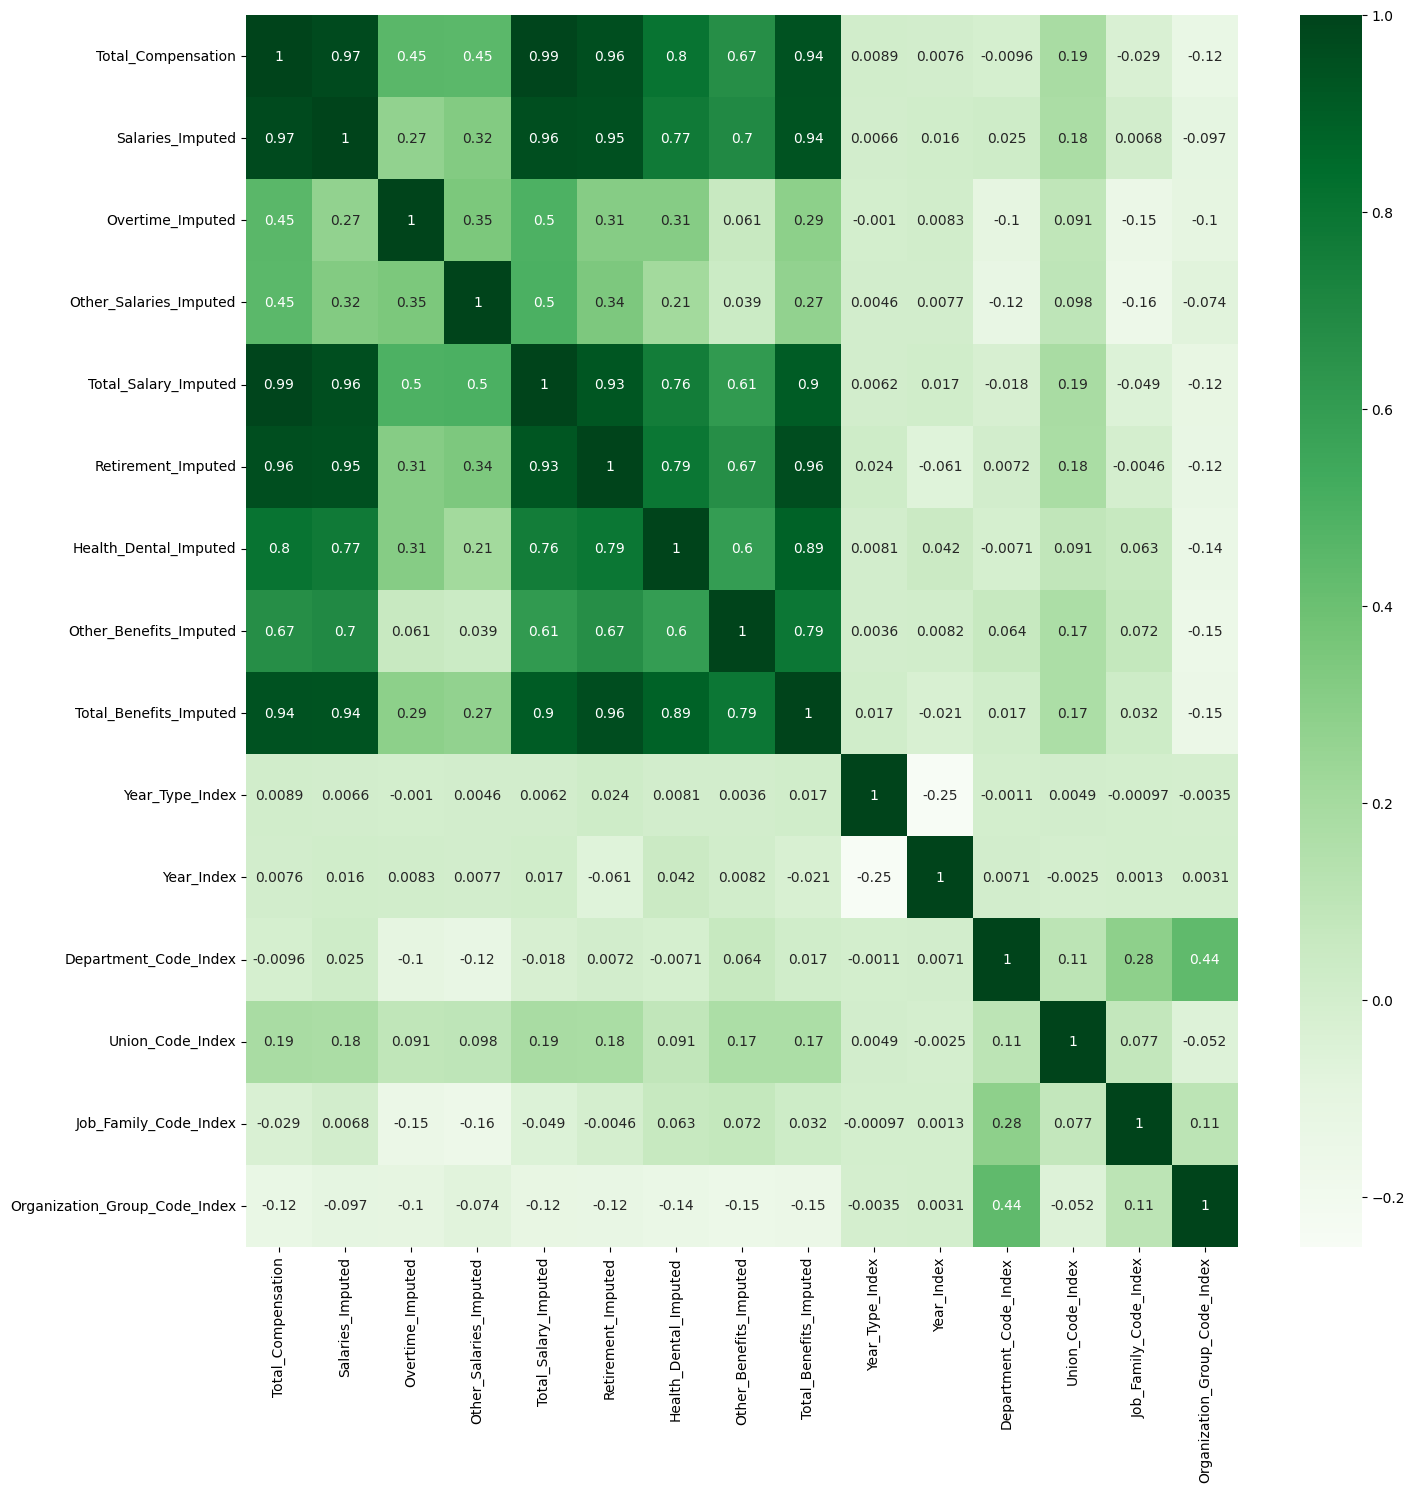

In [26]:
# Create Vector dataframe to compute the Correlation Matrix
vector_col = "Corr_Features"
assembler = VectorAssembler(inputCols=df.columns, outputCol=vector_col)
output = assembler.transform(df)
df_vector = output.select(vector_col)

# Get correlation matrix
matrix = Correlation.corr(df_vector, vector_col).collect()[0][0]
corr_matrix = matrix.toArray().tolist() 
corr_matrix_df = pd.DataFrame(data=corr_matrix, columns=df.columns) 

# Plot graph
plt.figure(figsize=(16,16))  
sns.heatmap(corr_matrix_df, xticklabels=corr_matrix_df.columns,\
            yticklabels=corr_matrix_df.columns, cmap="Greens", annot=True)

### 6. Perform necessary data pre-processing and divide the data into train and test set

### 6.1 Categorise the attributes into its type (Use one hot encoding wherever required)

In [27]:
# Apply One Hot Encoding on categorical features
df = OneHotEncoder(inputCols=["Year_Type_Index", "Year_Index", "Department_Code_Index", "Union_Code_Index",\
                                   "Job_Family_Code_Index", "Organization_Group_Code_Index"], \
                        outputCols=["Year_Type_Vec", "Year_Vec", "Department_Code_Vec", "Union_Code_Vec",\
                                   "Job_Family_Code_Vec", "Organization_Group_Code_Vec"]).fit(df).transform(df)
df = df.drop(*["Year_Type_Index", "Year_Index", "Department_Code_Index", "Union_Code_Index",\
                                   "Job_Family_Code_Index", "Organization_Group_Code_Index"])

In [28]:
# Create a vector dataframe to fit the models
feature_assembler = VectorAssembler(inputCols = df.columns, outputCol = "Independent_Features")
output = feature_assembler.transform(df)
dataset_final = output.select("Independent_Features", "Total_Compensation")

In [29]:
# Check final vectorized dataframe
dataset_final.show(5)

23/02/12 23:19:56 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
+--------------------+------------------+
|Independent_Features|Total_Compensation|
+--------------------+------------------+
|(195,[0,1,3,4,5,6...|         159436.66|
|(195,[0,1,4,5,6,7...|         120054.05|
|(195,[0,1,3,4,6,7...|          13868.64|
|(195,[0,1,4,6,7,8...|            3718.5|
|(195,[0,1,3,4,6,7...|          10128.64|
+--------------------+------------------+
only showing top 5 rows



### 6.2 Split the data into train and test set

In [30]:
# Split the data
(train, test) = dataset_final.randomSplit([0.70,0.30])

### 7. Fit Linear Regression model on the data and check its performance

In [38]:
# Train a Linear Regression model with appropriate parameters to avoid over or underfitting
lr = LinearRegression(featuresCol = 'Independent_Features', labelCol = 'Total_Compensation', \
                      regParam=0.3, elasticNetParam=0.8, maxIter=5)
lr_model = lr.fit(train)

prediction = lr_model.transform(train)

# Check model performance with RMSE and R2 metrics
r2_evaluator = RegressionEvaluator(labelCol="Total_Compensation", predictionCol="prediction", \
                                  metricName="r2").evaluate(prediction)
rmse_evaluator = RegressionEvaluator(labelCol="Total_Compensation", predictionCol="prediction", \
                                  metricName="rmse").evaluate(prediction)
print(f'Metrics of test data:\nR2 - {r2_evaluator}\nRMSE - {rmse_evaluator}')

Metrics of test data:
R2 - 0.9896935341673788
RMSE - 6875.287251019506


### 8. Fit Decision Tree Regression model on the data and check its performance (Optional)

In [35]:
# Train a Decision Tree Regression model with appropriate parameters to avoid over or underfitting
dt = DecisionTreeRegressor(featuresCol ='Independent_Features', labelCol = 'Total_Compensation',\
                          maxDepth=5, maxBins=22)
dt_model = dt.fit(train)
prediction = dt_model.transform(test)

# Check model performance with RMSE and R2 metrics
r2_evaluator = RegressionEvaluator(labelCol="Total_Compensation", predictionCol="prediction", \
                                  metricName="r2").evaluate(prediction)
rmse_evaluator = RegressionEvaluator(labelCol="Total_Compensation", predictionCol="prediction", \
                                  metricName="rmse").evaluate(prediction)
print(f'Metrics of test data:\nR2 - {r2_evaluator}\nRMSE - {rmse_evaluator}')

Metrics of test data:
R2 - 0.9928141784047239
RMSE - 5746.98866402743


### Model Persistence (Optional)
Model persistence means saving your model to a disk. After you finalize your model for prediction depending upon the performance, you need to save the model to the disk. Let's say, you finalize 'lrmodel' to be used for in production environment i.e. in your application. We use the following code to save it.

##### Saving the model

In [49]:
# use save() method to save the model
# write().overwrite() is usually used when you want to replace the older model with a new one
# It might happen that you wish to retrain your model and save it at the same the place
lr_model.write().overwrite().save(os.path.join(DATA_DIR, 'models/lr_model'))

##### Loading the model

In [61]:
# import PipelineModel from pyspark.ml package
# from pyspark.ml import PipelineModel

# load the model from the location it is stored
# The loaded model acts as PipelineModel
pipemodel = LinearRegressionModel.load(os.path.join(DATA_DIR, 'models/lr_model'))

# use the PipelineModel object to perform prediciton on test data. 
# Use .transform() to perfrom prediction
pipe_prediction = pipemodel.transform(test)

# print the results
# pipe_prediction.select('Total_Compensation', 'prediction').show(15)

# Check model performance with RMSE and R2 metrics
r2_evaluator = RegressionEvaluator(labelCol="Total_Compensation", predictionCol="prediction", \
                                  metricName="r2").evaluate(pipe_prediction)
rmse_evaluator = RegressionEvaluator(labelCol="Total_Compensation", predictionCol="prediction", \
                                  metricName="rmse").evaluate(pipe_prediction)
print(f'Metrics of test data:\nR2 - {r2_evaluator}\nRMSE - {rmse_evaluator}')

Metrics of test data:
R2 - 0.9897412876564097
RMSE - 6866.707548877419
